# Introduction

The objective of this project to segment customers from a client database. Since we're going to work with unlabeled data it is **unsupervised** and we're going to employ **clusterization** algorithms to create clusters of clients.

# About the data

Our data can be found on [kaggle](https://www.kaggle.com/datasets/vetrirah/customer) and contains client information from an automobile company. It contains the following features: 

Column | Description
-----------|-------------------
ID | Unique ID.
Gender | Gender of the customer
Ever_Married | Marital status of the customer.
Age | Age of the customer.
Graduated | Is the customer a graduate?
Profession | Profession of the customer.
Work_Experience | Work Experience in years.
Spending_Score | Spending score of the customer.
Family_Size | Number of family members for the customer (including the customer).
Var_1 | Anonymised Category for the customer.
Segmentation | Customer Segment of the customer (Target for Classification).


# Business question and evaluation

We're required to get insights from the client informations and segment them in groups, such that marketing and sales plans can be applied to them. With that, one could develop strategies to identify valuable customers, target campaings, etc. It is useful that the clusters have specific characteristics so our strategies fit well within those groups.

# Importing and exploring data

In [48]:
# Importing

import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [4]:
# Loading data

data = pd.read_csv('data/Train.csv')
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
# Shape

data.shape

(8068, 11)

> 8068 instances and 11 features. Its a reasonable sized dataset.

In [6]:
# Check for duplicates

data.duplicated().sum()

0

We won't need the `ID` anymore. Furthermore, since we're clustering, we can also drop `Var_1` and `Segmentation`.

In [7]:
# Drop columns we won't use

df = data.drop(['ID', 'Var_1', 'Segmentation'], axis=1)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 504.4+ KB


In [9]:
df.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [10]:
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


Since our objective is to characterize our clients, it's wise to don't bring any assumptions and impute the missing values. Instead, I'll only use complete data.

In [11]:
df_dropna = df.dropna()
df_dropna.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

# EDA

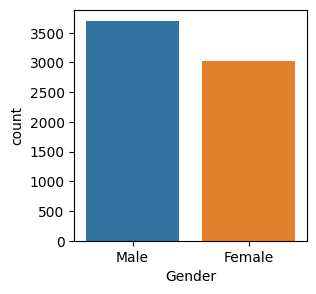

In [12]:
plt.figure(figsize=(3,3))
sns.countplot(df_dropna, x='Gender');

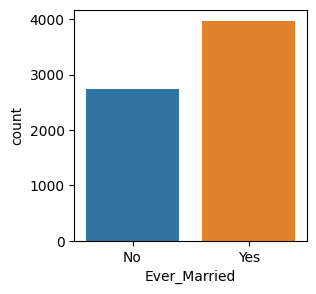

In [13]:
plt.figure(figsize=(3,3))
sns.countplot(df_dropna, x='Ever_Married');

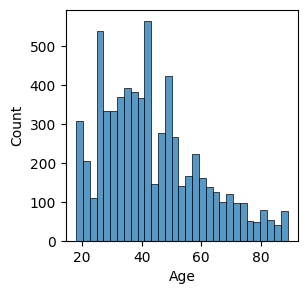

In [14]:
plt.figure(figsize=(3,3))
sns.histplot(df_dropna, x='Age');

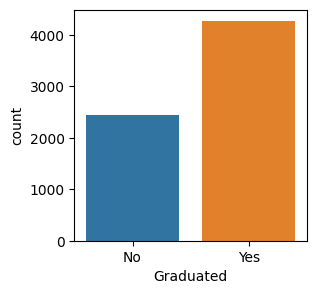

In [15]:
plt.figure(figsize=(3,3))
sns.countplot(df_dropna, x='Graduated');

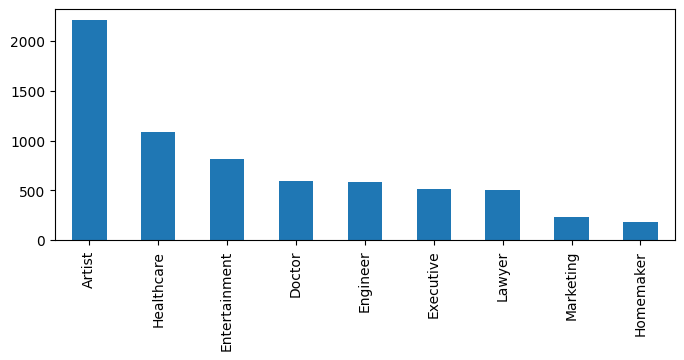

In [16]:
plt.figure(figsize=(8,3))
df_dropna['Profession'].value_counts().plot(kind='bar')
plt.show()

In [17]:
(100*df_dropna['Profession'].value_counts()) / df_dropna['Profession'].value_counts().sum() 

Artist           32.911581
Healthcare       16.210182
Entertainment    12.131587
Doctor            8.841917
Engineer          8.722834
Executive         7.576660
Lawyer            7.487347
Marketing         3.468294
Homemaker         2.649598
Name: Profession, dtype: float64

> About 33% of our clients are Artists. Artists, Healthcare, Entertainment, Doctor and Engineer represent about 80% of our data.

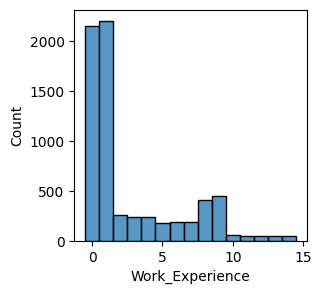

In [18]:
plt.figure(figsize=(3,3))
sns.histplot(df_dropna, x='Work_Experience', discrete=True);

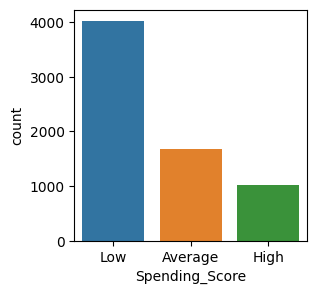

In [19]:
plt.figure(figsize=(3,3))
sns.countplot(df_dropna, x='Spending_Score', order=['Low', 'Average', 'High']);

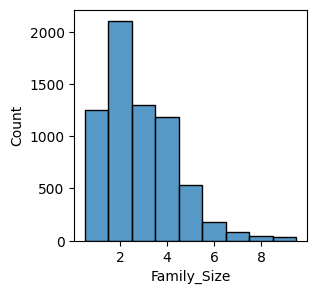

In [20]:
plt.figure(figsize=(3,3))
sns.histplot(df_dropna, x='Family_Size', discrete=True);

In [21]:
num_cols = ['Age', 'Work_Experience', 'Family_Size']
cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']

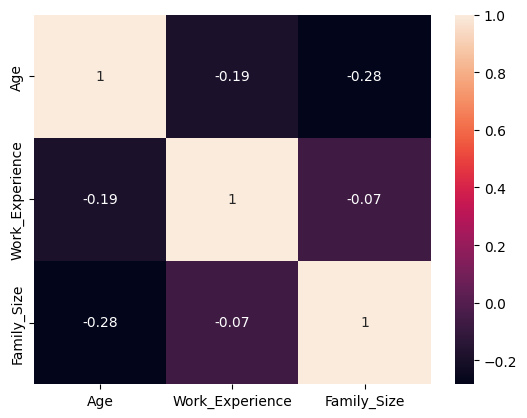

In [22]:
# Correlation with numerical features

corr_matrix = df_dropna[num_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

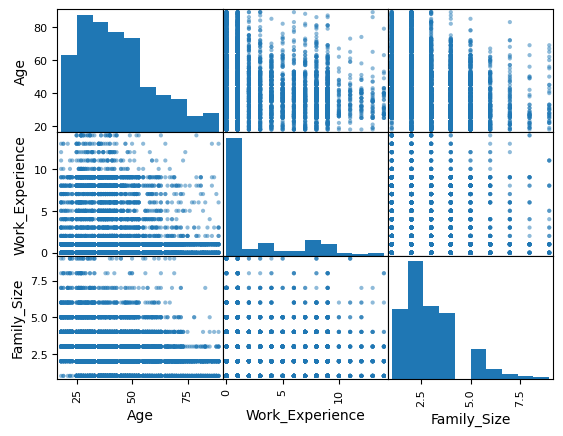

In [23]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_dropna[num_cols])
plt.show()

> Little to no correlation between `Family_Size` and `Work_Experience`. Negative correlation between `Age` and `Family_Size`, and `Age` and `Work_Experience`. All of them a bit unexpected.

# Treatment

In [24]:
def get_indexes(df, cols):
    df_cols = list(df.columns)
    indexes = []
    
    for col in cols:
        index = df_cols.index(col)
        indexes.append(index)
        
    return indexes

In [25]:
# ohe_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession']
# ord_cols = ['Spending_Score']
# num_cols = ['Age', 'Work_Experience', 'Family_Size']
# cat_cols = ohe_cols + ord_cols

# ordinal_enc = OrdinalEncoder(categories=[['Low', 'Average', 'High']])
# onehot_enc = OneHotEncoder(drop='first')
# std_scaler = StandardScaler()

# ct =  ColumnTransformer([('ordinal_enc', ordinal_enc, ord_cols),
#                          ('onehot_enc', onehot_enc, onehot_cols),
#                          ('std_scaler', std_scaler, num_cols)
#                         ])

# df_tr = ct.fit_transform(df_dropna)

In [26]:
ct =  ColumnTransformer([('std_scaler', StandardScaler(), num_cols)], remainder='passthrough')

df_tr = pd.DataFrame(ct.fit_transform(df_dropna), index=df_dropna.index, columns=num_cols+cat_cols)
df_tr.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score
0,-1.303562,-0.478692,0.760391,Male,No,No,Healthcare,Low
2,1.421748,-0.478692,-1.20914,Female,Yes,Yes,Engineer,Low
3,1.421748,-0.772431,-0.55263,Male,Yes,Yes,Lawyer,High
5,0.755561,-0.772431,-0.55263,Male,Yes,No,Artist,Average
6,-0.697937,-0.478692,0.103881,Male,No,Yes,Healthcare,Low


# Clustering

Typically the first approach to cluster data would be use the **KMeans** algorithm, but given that we're using a dataset with mixed categorical and numerical, it is better to use **KPrototypes**. KMeans would be better suited with numerical only data, and even if we encode our features, KMeans can't handle very well binary attributes.

## Finding k by elbow method

KPrototypes is not compatible with the default silhouete methods. Therefore, we've to stick with the elbow method to determine the number of clusters. That won't be a problem for us since 

In [35]:
# from kmodes.kprototypes import KPrototypes

# k_list = np.arange(1,9)
# inertia_list = []

# for k in k_list:
#     kprototypes = KPrototypes(n_clusters=k, max_iter=100, init='Huang', n_init=25,
#                               n_jobs=-1, random_state=42)
#     kprototypes.fit(df_tr.to_numpy(), categorical=get_indexes(df_tr, cat_cols))
#     inertia_list.append(kprototypes.cost_)

In [36]:
k_list = np.arange(1,9)

inertia_list = [27851.500000000106,
                21540.113628510728,
                16436.276660241074,
                14167.043121648308,
                12486.212367799326,
                11475.714806273721,
                10652.063586330649,
                10146.0266997184
               ]


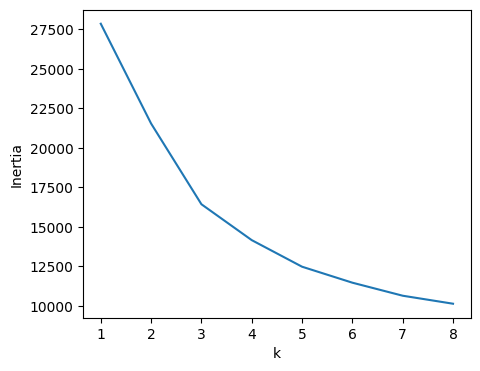

In [37]:
plt.figure(figsize=(5,4))
plt.plot(k_list, inertia_list)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

> Best result around $k = 3$ or $k = 4$.

In [39]:
from kneed import KneeLocator

k_knee = KneeLocator(x=k_list, y=inertia_list, S=0.1, curve='convex', direction='decreasing').elbow
print(k_knee)

3


> Again, $k=3$ sounds good. But I'll stick with $k = 4$ because it will lead to better clusters to interpret them.

# Analysis of the clusters

In [60]:
# from kmodes.kprototypes import KPrototypes

# # Fitting

# k = 4

# kprototypes = KPrototypes(n_clusters=k, max_iter=500, init='Huang', n_init=50,
#                           n_jobs=-1, random_state=42)

# kprototypes.fit(df_tr.to_numpy(), categorical=get_indexes(df_tr, cat_cols))

# # Saving the fitted model

# joblib.dump(kprototypes, 'models/kprototypes.pkl')

In [61]:
# Loading the fitted model

kprototypes = joblib.load('models/kprototypes.pkl')

In [62]:
labels = kprototypes.labels_

In [63]:
df_results = df_dropna.join(pd.Series(labels, name='Label', index=df_dropna.index))

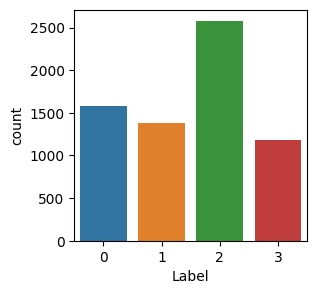

In [64]:
plt.figure(figsize=(3,3))
sns.countplot(df_results, x='Label');

> Label 2 is the biggest cluster.

In [65]:
# Analysing mean of numerical features

df_results[num_cols + ['Label']].groupby('Label').mean()

,Age,Work_Experience,Family_Size
Label,,,
0,30.106032,1.455238,4.668571
1,37.860566,8.471314,2.402324
2,42.227431,0.989539,2.265014
3,70.764557,0.974684,2.180591


In [66]:
# Table with modes for the categorical features
df_results[cat_cols + ['Label']].groupby('Label').agg(lambda x: pd.Series.mode(x))

,Gender,Ever_Married,Graduated,Profession,Spending_Score
Label,,,,,
0,Male,No,No,Healthcare,Low
1,Female,Yes,Yes,Artist,Low
2,Male,Yes,Yes,Artist,Low
3,Male,Yes,Yes,Lawyer,High


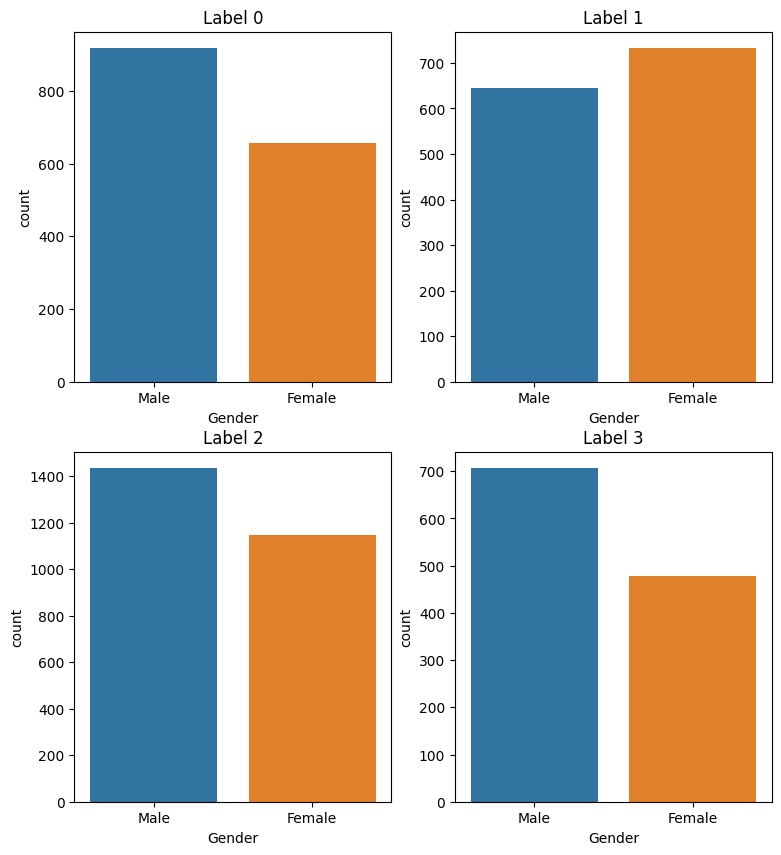

In [67]:
plt.figure(figsize=(9,10))

plt.subplot(2,2,1)
sns.countplot(df_results[df_results['Label'] == 0], x='Gender', order=['Male', 'Female'])
plt.title('Label 0')

plt.subplot(2,2,2)
sns.countplot(df_results[df_results['Label'] == 1], x='Gender', order=['Male', 'Female'])
plt.title('Label 1')

plt.subplot(2,2,3)
sns.countplot(df_results[df_results['Label'] == 2], x='Gender', order=['Male', 'Female'])
plt.title('Label 2')

plt.subplot(2,2,4)
sns.countplot(df_results[df_results['Label'] == 3], x='Gender', order=['Male', 'Female'])
plt.title('Label 3')

plt.show()

> Somewhat simillar distribution. Label 1 is slightly more feminine.

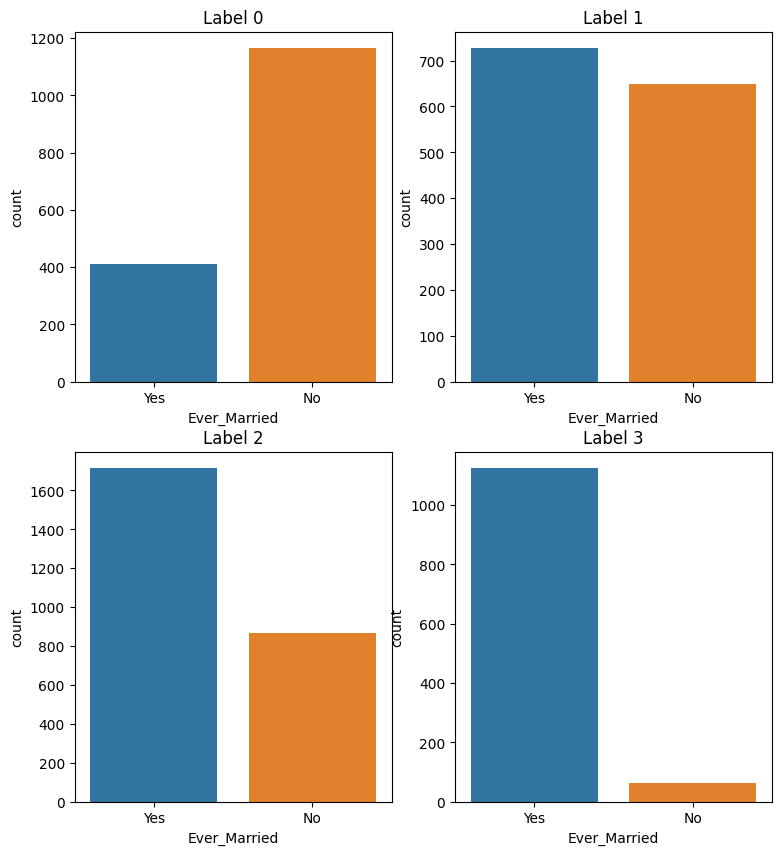

In [68]:
plt.figure(figsize=(9,10))

plt.subplot(2,2,1)
sns.countplot(df_results[df_results['Label'] == 0], x='Ever_Married', order=['Yes', 'No'])
plt.title('Label 0')

plt.subplot(2,2,2)
sns.countplot(df_results[df_results['Label'] == 1], x='Ever_Married', order=['Yes', 'No'])
plt.title('Label 1')

plt.subplot(2,2,3)
sns.countplot(df_results[df_results['Label'] == 2], x='Ever_Married', order=['Yes', 'No'])
plt.title('Label 2')

plt.subplot(2,2,4)
sns.countplot(df_results[df_results['Label'] == 3], x='Ever_Married', order=['Yes', 'No'])
plt.title('Label 3')

plt.show()

> Cluster 3 is noteworthy: unlike the other clusters it contais mostly married clients.

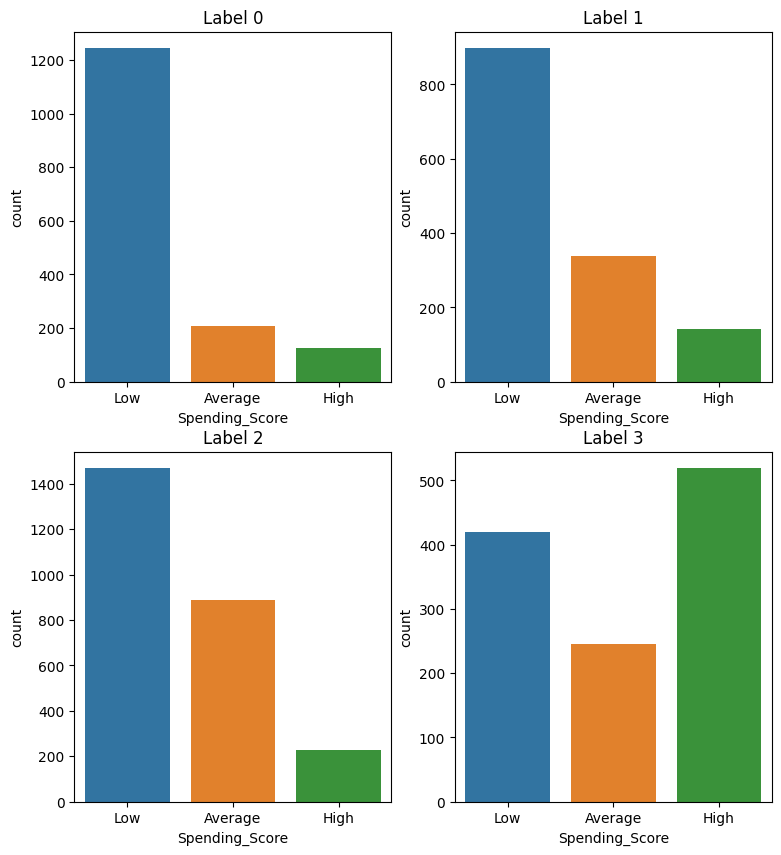

In [69]:
plt.figure(figsize=(9,10))

plt.subplot(2,2,1)
sns.countplot(df_results[df_results['Label'] == 0], x='Spending_Score', order=['Low', 'Average', 'High'])
plt.title('Label 0')

plt.subplot(2,2,2)
sns.countplot(df_results[df_results['Label'] == 1], x='Spending_Score', order=['Low', 'Average', 'High'])
plt.title('Label 1')

plt.subplot(2,2,3)
sns.countplot(df_results[df_results['Label'] == 2], x='Spending_Score', order=['Low', 'Average', 'High'])
plt.title('Label 2')

plt.subplot(2,2,4)
sns.countplot(df_results[df_results['Label'] == 3], x='Spending_Score', order=['Low', 'Average', 'High'])
plt.title('Label 3')

plt.show()

> Cluster 0 is an interesting target: it contains a lot of clients that spend little. In contrast, cluster 3 contains majoritary clients that already spend a higher amount.

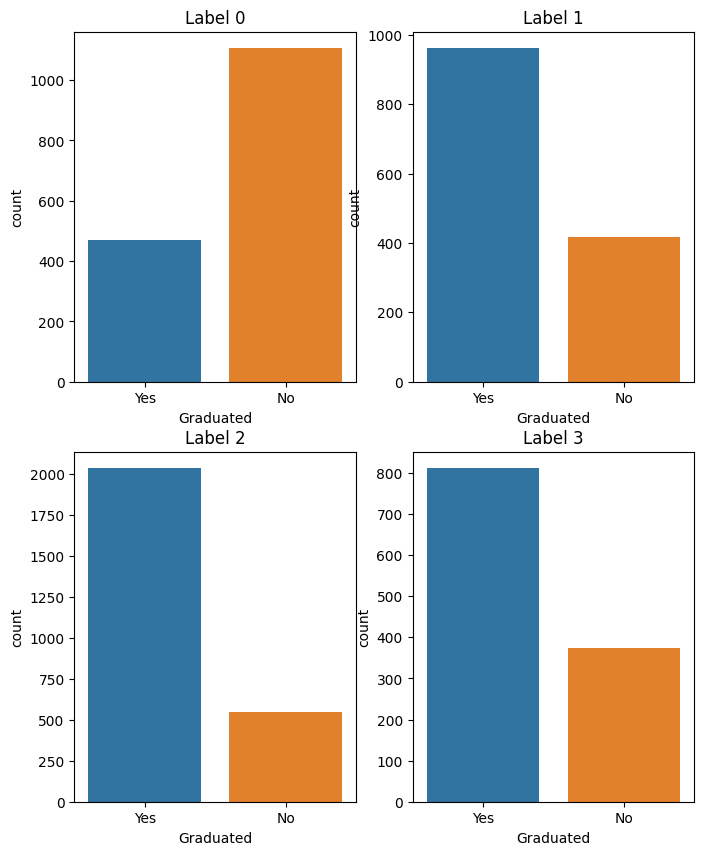

In [70]:
plt.figure(figsize=(8,10))

plt.subplot(2,2,1)
sns.countplot(df_results[df_results['Label'] == 0], x='Graduated', order=['Yes', 'No'])
plt.title('Label 0')

plt.subplot(2,2,2)
sns.countplot(df_results[df_results['Label'] == 1], x='Graduated', order=['Yes', 'No'])
plt.title('Label 1')

plt.subplot(2,2,3)
sns.countplot(df_results[df_results['Label'] == 2], x='Graduated', order=['Yes', 'No'])
plt.title('Label 2')

plt.subplot(2,2,4)
sns.countplot(df_results[df_results['Label'] == 3], x='Graduated', order=['Yes', 'No'])
plt.title('Label 3')

plt.show()

> Most of the Cluster 0 are ungraduated clients. A large percentage of Cluster 2 is graduated.

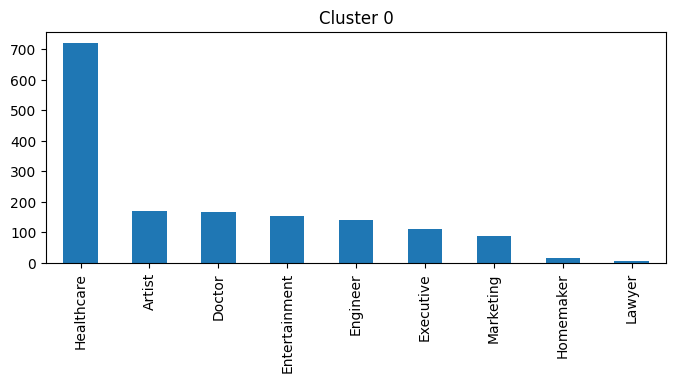

In [71]:
plt.figure(figsize=(8,3))
plt.title('Cluster 0')
df_results[df_results['Label'] == 0]['Profession'].value_counts().plot(kind='bar')
plt.show()

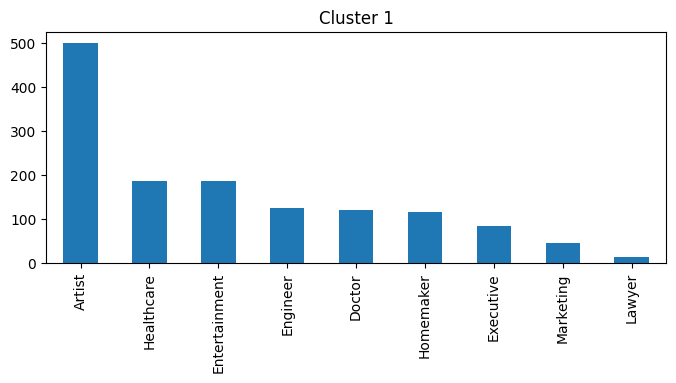

In [72]:
plt.figure(figsize=(8,3))
plt.title('Cluster 1')
df_results[df_results['Label'] == 1]['Profession'].value_counts().plot(kind='bar')
plt.show()

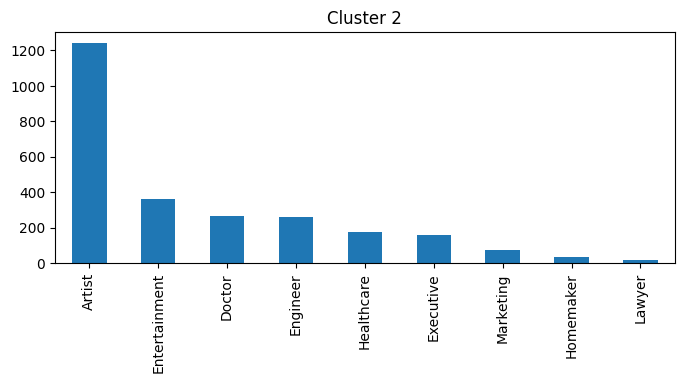

In [73]:
plt.figure(figsize=(8,3))
plt.title('Cluster 2')
df_results[df_results['Label'] == 2]['Profession'].value_counts().plot(kind='bar')
plt.show()

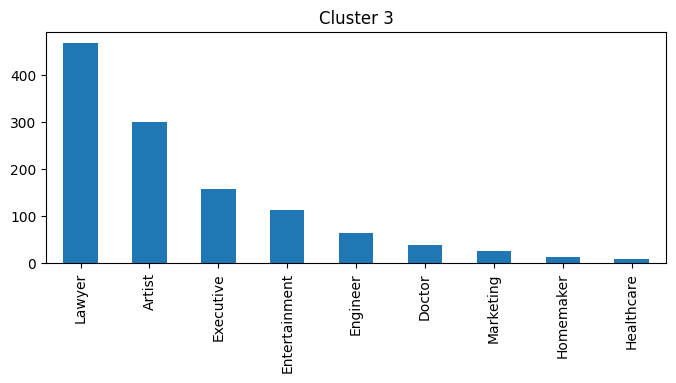

In [74]:
plt.figure(figsize=(8,3))
plt.title('Cluster 3')
df_results[df_results['Label'] == 3]['Profession'].value_counts().plot(kind='bar')
plt.show()

> Cluster 0 is formed mostly by heathcare workers (which is the second most prevalent profession)

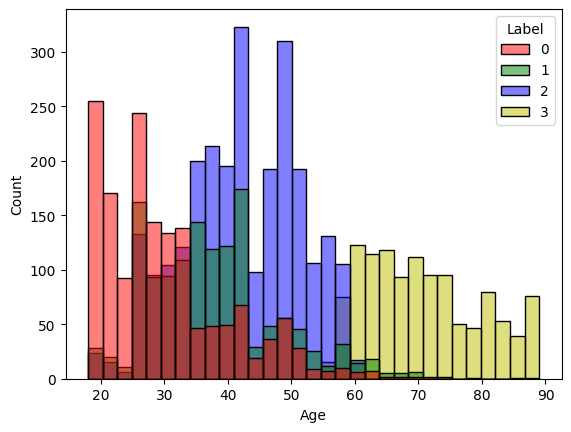

In [75]:
sns.histplot(df_results, x='Age', hue='Label', palette=['r','g','b','y']);

> Our clusters are coincidently in age order. This can be used to target products by age.

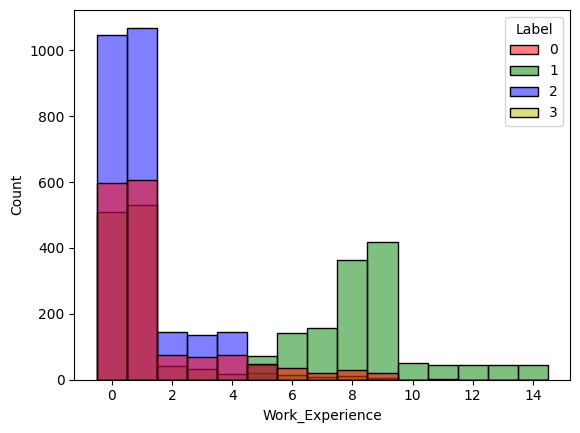

In [76]:
sns.histplot(df_results, x='Work_Experience', hue='Label', palette=['r','g','b','y'], discrete=True);

> People with low work experience are most present in Cluster 2. Cluster 1 contains experienced workers.

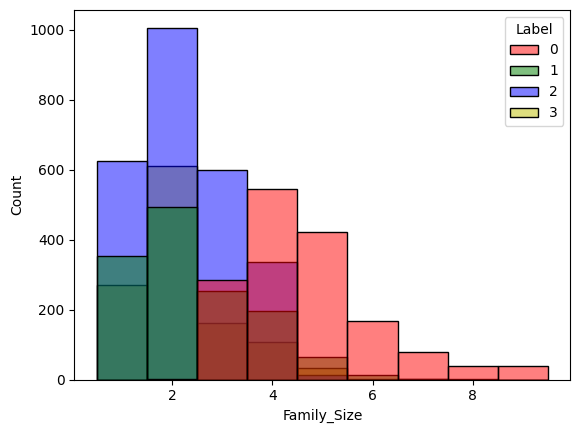

In [77]:
sns.histplot(df_results, x='Family_Size', hue='Label', palette=['r','g','b','y'], discrete=True);

> Many clients of cluster 0 contains a considerably family size.

## KMeans + PCA clusterization

In [136]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

ordinal_enc = OrdinalEncoder(categories=[['Low', 'Average', 'High']])
std_scaler = StandardScaler()

X = df_dropna.drop(['Gender', 'Ever_Married', 'Graduated', 'Profession'], axis=1)

ct_ordinal = ColumnTransformer([('ordinal', ordinal_enc, ['Spending_Score'])], remainder='passthrough')

pipeline = Pipeline([('encode', ct_ordinal), ('scale', std_scaler)])

pipeline.set_output(transform="pandas")

X_tr = pipeline.fit_transform(X)

<IPython.core.display.Javascript object>


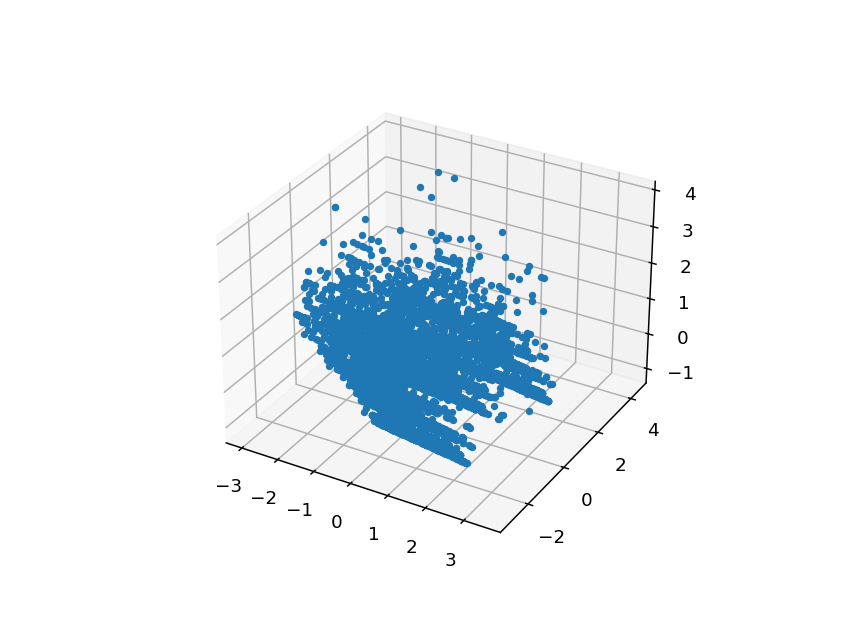

In [146]:
%matplotlib notebook

from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)

X_tr_pca = pca.fit_transform(X_tr)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(X_tr_pca[:,0], X_tr_pca[:,1], X_tr_pca[:,2], marker='.', ls='')
plt.show()

In [138]:
pca.explained_variance_ratio_.sum()

0.8962633404535973

In [143]:
from sklearn.cluster import KMeans

# Find the number of clusters

k_values = np.arange(2,10)
inertia = np.zeros(k_values.shape)

for idx, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X_tr_pca)
    inertia[idx] = kmeans.inertia_

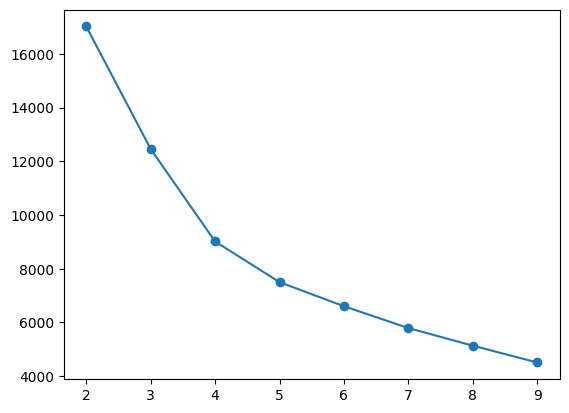

In [151]:
%matplotlib inline
plt.plot(k_values, inertia, marker='o')
plt.show()

In [ ]:
# Silhouette



In [152]:
# Visualizing clusters

kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(X_tr_pca)

KMeans(n_clusters=4, n_init=10)

<IPython.core.display.Javascript object>


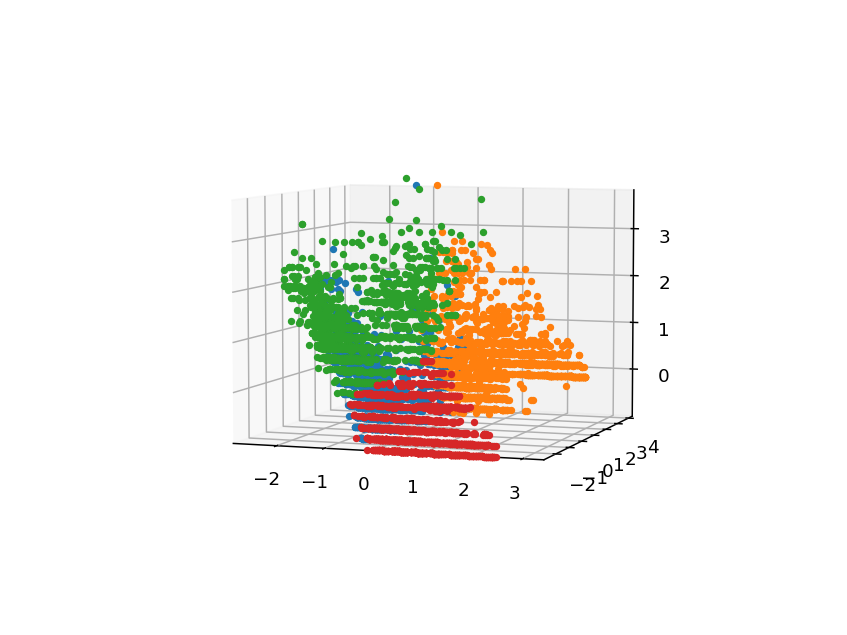

In [163]:
%matplotlib notebook

from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)

X_tr_pca = pca.fit_transform(X_tr)

labels= kmeans.labels_

ax = plt.figure().add_subplot(projection='3d')
ax.plot(X_tr_pca[labels == 0][:,0], X_tr_pca[labels == 0][:,1], X_tr_pca[labels == 0][:,2], marker='.', ls='')
ax.plot(X_tr_pca[labels == 1][:,0], X_tr_pca[labels == 1][:,1], X_tr_pca[labels == 1][:,2], marker='.', ls='')
ax.plot(X_tr_pca[labels == 2][:,0], X_tr_pca[labels == 2][:,1], X_tr_pca[labels == 2][:,2], marker='.', ls='')
ax.plot(X_tr_pca[labels == 3][:,0], X_tr_pca[labels == 3][:,1], X_tr_pca[labels == 3][:,2], marker='.', ls='')
plt.show()

In [159]:
X_tr_pca[kmeans.labels_ == 0]

array([[-1.3943172 ,  0.8087522 , -0.63543839],
       [-0.80845337,  0.15875648, -0.76641929],
       [-0.76527514,  0.14875903, -0.76525283],
       ...,
       [ 0.29941491,  2.2033849 ,  0.11733124],
       [-1.0145285 ,  0.43847629, -0.12983352],
       [-1.17842607,  0.75876496, -0.6296061 ]])

In [157]:
X_labels = np.c_[X_tr_pca, kmeans.labels_]

# Conclusions

We segmented our client database in four clusters which are summarized as:

> **Cluster 0**: Low spending, never married, not graduated, healthcare workers, younger;

> **Cluster 1**: Low/Average spending, mostly females, highest work experience;

> **Cluster 2**: Artists/Entertainers, married, graduated;

> **Cluster 3**: High spending, married, lawyers, older;


Some potential strategies that can be suggested based on this segmentation are

* There is potential to create strategies to expand spending in Cluster 0. The cluster is particularly well described and plans to target those clients can be very precise. In contrast, Cluster 3 contains clients that already have high spending;

* Specific campaigns to women can be created to clients in Cluster 1;